# Starbucks Capstone Challenge

### Introduction


Starbucks is considered as one of the best coffee chains on the planet. It is likewise one of the pioneers to present its own reward applications in 2010. Clients can get limited time offers notices, by order and pay through the mobile app they earn reward for their transactions. Once every few days, Starbucks sends an offer to some users of the mobile app. An offer can be just an advertisement for a drink or an actual offer such as a discount or buy one get one free. This allows Starbucks to gather significant direct client data just as their transaction behaviors. Not all users receive the same offer, and that is this is what we want to solve with this data set. we have to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type, We want to build machine learning model to predict if the offers we be completed or not by only knowing his/her age, gender, income.


 

### Data Exploration / Data understanding

In our project we have three data sets as following with details:
Portfolio dataset: Data on the different offers given, like offer type, reward, duration and difficulty.
Profile dataset: Data about the users. Age, income, gender.
Transcript dataset: All the information about the behavior of the user. Transcript of all events during the test period. Which user got what offer at what time, when did they view it, what did they purchase etc.


In [1]:
# import libraries
import pandas as pd
import numpy as np
import json
import math
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Imputer,LabelEncoder,OneHotEncoder

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


#### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### Data preparation / Wrangling
In this part, I will review the data and make some data controversy and fix some problems with elements such as value. 
The data will be divided and arranged, making it easier to use with the analytical steps.


In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

One of the problems for this data set is that the channel column will be divided into three digital columns. 

In [4]:
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(portfolio['channels']),
                   columns=mlb.classes_,
                   index=portfolio['channels'].index)
portfolio = portfolio.drop('channels', axis=1)
portfolio = pd.concat([portfolio, res], axis=1, sort=False)
portfolio

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [5]:
portfolio['duration'] = portfolio['duration'] * 24

In [6]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [7]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [8]:
profile[profile.age==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [9]:
profile[profile.age==118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [10]:
profile.drop(profile[profile.age == 118].index, inplace=True)

In [11]:
profile[profile.age==118].count()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

### Analysis

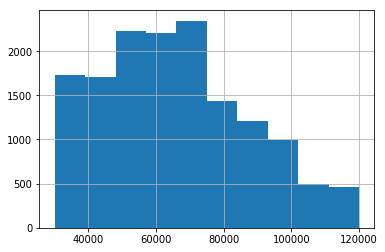

In [12]:
profile.income.hist()

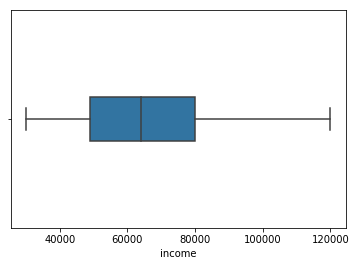

In [13]:
sns.boxplot(profile['income'], width=0.2);

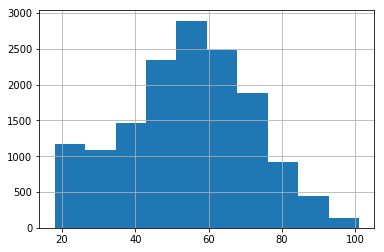

In [14]:
profile.age.hist()

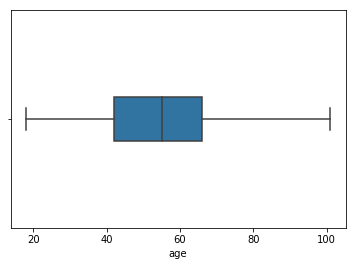

In [15]:
sns.boxplot(profile['age'], width=0.2);

In [16]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [17]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [18]:
keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

keys

['offer id', 'amount', 'offer_id', 'reward']

In [19]:
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            transcript.at[idx, 'offer_id']= row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount']= row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward']= row['value'][k]

In [20]:
transcript.head()

,event,person,time,value,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [21]:
transcript.drop(columns='value' , inplace=True)

In [28]:
transcript.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [23]:
combine = pd.merge(transcript , profile ,left_on='person' , right_on='id',how='inner')
combine.drop(columns=['id'] , inplace=True)

In [24]:
combine.head(10)

,event,person,time,offer_id,amount,reward,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75,20170509,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75,20170509,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,,19,0,75,20170509,F,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,75,20170509,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,,17,0,75,20170509,F,100000.0
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,0,75,20170509,F,100000.0
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,0,0,75,20170509,F,100000.0
7,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,,19,0,75,20170509,F,100000.0
8,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,,29,0,75,20170509,F,100000.0
9,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,,23,0,75,20170509,F,100000.0


In [25]:
combine = combine.merge(portfolio , left_on='offer_id' , right_on='id'  ,how='left')
combine.head()

,event,person,time,offer_id,amount,reward_x,age,became_member_on,gender,income,difficulty,duration,id,offer_type,reward_y,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75,20170509,F,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75,20170509,F,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,,19,0,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,75,20170509,F,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,,17,0,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
combine.isnull().sum()

event                    0
person                   0
time                     0
offer_id                 0
amount                   0
reward_x                 0
age                      0
became_member_on         0
gender                   0
income                   0
difficulty          123957
duration            123957
id                  123957
offer_type          123957
reward_y            123957
email               123957
mobile              123957
social              123957
web                 123957
dtype: int64

In [30]:
total_trans_g_o = combine[combine["gender"] != 'NA'].groupby(['gender','offer_type']).count()
total_trans_g_e = combine[combine["gender"] != 'NA'].groupby(['gender','event']).count()

In [31]:
total_trans_g_o, total_trans_g_e

(                      event  person   time  offer_id  amount  reward_x    age  \
 gender offer_type                                                               
 F      bogo           27619   27619  27619     27619   27619     27619  27619   
        discount       26652   26652  26652     26652   26652     26652  26652   
        informational   9448    9448   9448      9448    9448      9448   9448   
 M      bogo           35301   35301  35301     35301   35301     35301  35301   
        discount       34739   34739  34739     34739   34739     34739  34739   
        informational  12856   12856  12856     12856   12856     12856  12856   
 O      bogo             914     914    914       914     914       914    914   
        discount         920     920    920       920     920       920    920   
        informational    356     356    356       356     356       356    356   
 
                       became_member_on  income  difficulty  duration     id  \
 gender offer_ty

In [70]:
total_trans_go_o_t = total_trans_g_o.loc[('F')]['event'].sum()
total_trans_go_o_tt = total_trans_g_o.loc[('M')]['event'].sum()
total_trans_go_o_t_offers_f = total_trans_g_o.loc[('F')].loc[['bogo', 'discount', 'informational']]['event'].sum()
total_trans_go_o_t_offers_m = total_trans_g_o.loc[('M')].loc[['bogo', 'discount', 'informational']]['event'].sum()

print('For Females:')
print(f'Total transcipts is: {total_trans_go_o_t}.')
print(f"Number of offer completed: {total_trans_g_e.loc[('F', 'offer completed')].values[0]}, {round((total_trans_g_e.loc[('F', 'offer completed')].values[0]/total_trans_g_e.loc[('F', 'offer received')].values[0])*100,2)}% of total offers received.")

print('\nFor Males:')
print(f'Total transcipts is: {total_trans_go_o_tt}.')
print(f"Number of offer completed: {total_trans_g_e.loc[('M', 'offer completed')].values[0]}, {round((total_trans_g_e.loc[('M', 'offer completed')].values[0]/total_trans_g_e.loc[('M', 'offer received')].values[0])*100,2)}% of total offers received.")


For Females:
Total transcipts is: 63719.
Number of offer completed: 15477, 56.37% of total offers received.

For Males:
Total transcipts is: 82896.
Number of offer completed: 16466, 43.18% of total offers received.


In [32]:
combine['ages'] = pd.cut(combine.age, bins=[9, 18, 23, 30, 50, 150], labels=['kid', 'teenager', 'young adult', 'adult', 'elderly'])

In [33]:
combine.head()

,event,person,time,offer_id,amount,reward_x,age,became_member_on,gender,income,difficulty,duration,id,offer_type,reward_y,email,mobile,social,web,ages
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75,20170509,F,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0,elderly
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75,20170509,F,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0,elderly
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,,19,0,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,elderly
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,75,20170509,F,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0,elderly
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,,17,0,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,elderly


In [34]:
combine['ages'].replace(to_replace=['kid','teenager', 'young adult', 'adult','elderly'], value=[1, 2,3,4,5], inplace=True)

In [35]:
combine.head()

,event,person,time,offer_id,amount,reward_x,age,became_member_on,gender,income,difficulty,duration,id,offer_type,reward_y,email,mobile,social,web,ages
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75,20170509,F,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0,5
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75,20170509,F,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0,5
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,,19,0,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,75,20170509,F,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,0.0,1.0,5
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,,17,0,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [36]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 20 columns):
event               272762 non-null object
person              272762 non-null object
time                272762 non-null int64
offer_id            272762 non-null object
amount              272762 non-null int64
reward_x            272762 non-null int64
age                 272762 non-null int64
became_member_on    272762 non-null int64
gender              272762 non-null object
income              272762 non-null float64
difficulty          148805 non-null float64
duration            148805 non-null float64
id                  148805 non-null object
offer_type          148805 non-null object
reward_y            148805 non-null float64
email               148805 non-null float64
mobile              148805 non-null float64
social              148805 non-null float64
web                 148805 non-null float64
ages                272762 non-null int64
dtypes: float64(8), int64(6

In [37]:
combine.offer_id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', '',
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5',
       '3f207df678b143eea3cee63160fa8bed',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '4d5c57ea9a6940dd891ad53e9dbe8da0'], dtype=object)

In [38]:
combine.gender.unique()

array(['F', 'M', 'O'], dtype=object)

In [39]:
combine.offer_type.unique()

array(['bogo', nan, 'informational', 'discount'], dtype=object)

In [40]:
combine.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [41]:
combine['offer_type'].replace(to_replace=['bogo','discount', 'informational',], value=[1, 2,3], inplace=True)

In [42]:
combine['gender'].replace(to_replace=['O', 'F', 'M'], value=[0, 1, 2], inplace=True)

In [43]:
combine['offer_id'].replace(to_replace=['fafdcd668e3743c1bb461111dcafc2a4','2298d6c36e964ae4a3e7e9706d1fb8c2', 'f19421c1d4aa40978ebb69ca19b0e20d', '4d5c57ea9a6940dd891ad53e9dbe8da0','ae264e3637204a6fb9bb56bc8210ddfd','9b98b8c7a33c4b65b9aebfe6a799e6d9','2906b810c7d4411798c6938adc9daaa5','5a8bc65990b245e5a138643cd4eb9837','0b1e1539f2cc45b7b9fa7c272da2e1d7','3f207df678b143eea3cee63160fa8bed'], value=[1,2,3,4,5,6,7,8,9,10], inplace=True)

In [44]:
combine['event'].replace(to_replace=['transaction','offer completed', 'offer received', 'offer viewed'], value=[0, 1, 2,3], inplace=True)

In [45]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 20 columns):
event               272762 non-null int64
person              272762 non-null object
time                272762 non-null int64
offer_id            272762 non-null object
amount              272762 non-null int64
reward_x            272762 non-null int64
age                 272762 non-null int64
became_member_on    272762 non-null int64
gender              272762 non-null int64
income              272762 non-null float64
difficulty          148805 non-null float64
duration            148805 non-null float64
id                  148805 non-null object
offer_type          148805 non-null float64
reward_y            148805 non-null float64
email               148805 non-null float64
mobile              148805 non-null float64
social              148805 non-null float64
web                 148805 non-null float64
ages                272762 non-null int64
dtypes: float64(9), int64(8)

In [46]:
combine.head()

,event,person,time,offer_id,amount,reward_x,age,became_member_on,gender,income,difficulty,duration,id,offer_type,reward_y,email,mobile,social,web,ages
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,6,0,0,75,20170509,1,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,5.0,1.0,1.0,0.0,1.0,5
1,3,78afa995795e4d85b5d9ceeca43f5fef,6,6,0,0,75,20170509,1,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,5.0,1.0,1.0,0.0,1.0,5
2,0,78afa995795e4d85b5d9ceeca43f5fef,132,,19,0,75,20170509,1,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,1,78afa995795e4d85b5d9ceeca43f5fef,132,6,0,5,75,20170509,1,100000.0,5.0,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,5.0,1.0,1.0,0.0,1.0,5
4,0,78afa995795e4d85b5d9ceeca43f5fef,144,,17,0,75,20170509,1,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [47]:
combine.drop(combine[combine.event == 0].index, inplace=True)

In [48]:
combine = combine.drop(['reward_y','age','became_member_on','difficulty','duration','web','social','mobile','email'], axis = 1)

In [49]:
combine.head()

,event,person,time,offer_id,amount,reward_x,gender,income,id,offer_type,ages
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,6,0,0,1,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,5
1,3,78afa995795e4d85b5d9ceeca43f5fef,6,6,0,0,1,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,5
3,1,78afa995795e4d85b5d9ceeca43f5fef,132,6,0,5,1,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,5
5,2,78afa995795e4d85b5d9ceeca43f5fef,168,8,0,0,1,100000.0,5a8bc65990b245e5a138643cd4eb9837,3.0,5
6,3,78afa995795e4d85b5d9ceeca43f5fef,216,8,0,0,1,100000.0,5a8bc65990b245e5a138643cd4eb9837,3.0,5


Split the data into features and target label

In [50]:
target = combine['offer_type']
features = combine.drop(['id','person', 'offer_type'], axis = 1)

In [51]:
features.head()

,event,time,offer_id,amount,reward_x,gender,income,ages
0,2,0,6,0,0,1,100000.0,5
1,3,6,6,0,0,1,100000.0,5
3,1,132,6,0,5,1,100000.0,5
5,2,168,8,0,0,1,100000.0,5
6,3,216,8,0,0,1,100000.0,5


In [52]:
target.head()

0    1.0
1    1.0
3    1.0
5    3.0
6    3.0
Name: offer_type, dtype: float64

### Modeling

Creating training and testing sets

In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

In [55]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (111603, 8)
Training Labels Shape: (111603,)
Testing Features Shape: (37202, 8)
Testing Labels Shape: (37202,)


I'll used different models to pick the best out of them.

1. LogisticRegression

In [56]:
def pred_score(model):
    pred = model.predict(X_test)
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    # Calculate mean absolute percentage error
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    return round(accuracy, 2)

In [57]:
from sklearn.linear_model import LogisticRegression

LogisticR = LogisticRegression()

LogisticR.fit(X_train, y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(LogisticR.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(LogisticR)}%')

Accuracy of Logistic regression classifier on training set: 49.75%.
Prediction Accuracy: 60.13%


2. K-Nearest Neighbors

In [58]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(knn)}%')

Accuracy of K-NN classifier on training set: 87.22%.
Prediction Accuracy: 86.12%


3. Random Forest Classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [60]:
random_forest_model = RandomForestClassifier(random_state = 0)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [61]:
y_pred = random_forest_model.predict(X_test)
print("Model accruracy score: {}".format(accuracy_score(y_test, y_pred)))

Model accruracy score: 0.9997043169722057


In [62]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00     16149
        2.0       1.00      1.00      1.00     15526
        3.0       1.00      1.00      1.00      5527

avg / total       1.00      1.00      1.00     37202



4.  Naive Bayes

In [63]:
from sklearn.naive_bayes import GaussianNB 

NaiveB = GaussianNB() 
NaiveB.fit(X_train, y_train) 
print(f'Accuracy of SVM classifier on training set: {round(NaiveB.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(NaiveB)}%')

Accuracy of SVM classifier on training set: 72.08%.
Prediction Accuracy: 78.31%


5. Decision Tree

In [64]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


6. Random Forest

In [65]:
from sklearn.ensemble import RandomForestRegressor

RandomF = RandomForestRegressor(n_estimators = 100, random_state = 42)

RandomF.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(RandomF.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(RandomF)}%')

Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


### Models Results

In [66]:
models = [LogisticR, knn, random_forest_model, NaiveB, dt, RandomF]
model_names = [type(n).__name__ for n in models]
tr_accuracy = [x.score(X_train, y_train)*100 for x in models]
pred_accuracy = [pred_score(y) for y in models]

In [67]:
results = [tr_accuracy, pred_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accureacy']) 
results_df

,LogisticRegression,KNeighborsClassifier,RandomForestClassifier,GaussianNB,DecisionTreeClassifier,RandomForestRegressor
Training Accuracy,49.748663,87.224358,100.00,72.082292,100.0,100.0
Predicting Accureacy,60.130000,86.120000,99.99,78.310000,100.0,100.0


### Model Improvements


From the previous table, we can see that we scored 100% accuracy in the training and testing datasets on 3 models. 
I will choose 	KNeighborsClassifier since it got good results 87% on training and 86% on testing datasets.


In [68]:
dual = [True, False]
max_iter = [100, 120, 140, 160]
C = [1.0,1.5]
param_grid = dict(dual = dual, max_iter = max_iter, C = C)

LogisticR = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator = LogisticR, param_grid = param_grid, cv = 3, n_jobs = -1)
grid_result = grid.fit(X_train, y_train)

print(f'Best Score: {grid_result.best_score_}')
print(f'Best params: {grid_result.best_params_}')

Best Score: 0.49207458580862523
Best params: {'C': 1.0, 'dual': False, 'max_iter': 100}


### Conclusion

First, we have explored every set of data, imagine it to get a general understanding of the data. It also included the study of various aspects of the data sets. Then, we moved to Part Pre-processing. Pre-processing Data was the most time- and effort-intensive task. The collection of data is a little complicated and the included data allowed me to use my wrangling / engineering and pre-processing expertise to get the final clean version of the three data sets. It was time to execute a fast review on that Master data set, after having a clean Master data set, Overall, our final perspective shows that we have been operating on the Analysis and Modeling phase must be focusing BOGO offer because this offer the most completed offer compared to other offers and focusing on female also will increase the chances of that offer will be completed. Because Females tend to complete offers more than males with 56% completion of the offers they received. Where Males completed only 43.18% from the offers they received. 

### Improvements

I think I have reached a stage where we have achieved good results and understand the data that we have very well. But to make our results better, I will try to improve my data collection and fix the problems I face with NaN values. Getting more data is always good to help us improve the results of our model.